In [20]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter
import dask_searchcv as dcv
from distributed import Executor
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.externals.joblib import Parallel, parallel_backend, \
    register_parallel_backend
from distributed.joblib import DistributedBackend
%matplotlib inline

In [2]:
from dalila.parameters_research import tune_parameters
from dalila.dictionary_learning import DictionaryLearning
from dalila.penalty import L1Penalty
from dalila.cv_splitting import MonteCarloBootstrap

In [3]:
from utils import *

In [4]:
from scipy.io import loadmat
from unicodedata import normalize
filename = "/home/veronica/Desktop/UVM/mutation_signatures/datasets/breast_cancer_data.mat"
data = loadmat(filename, appendmat=False)
v = data["originalGenomes"]
types = data["types"]
l = len(types)
types_1 = [None] * l
for i in range(0, l):
    types_1[i] = normalize('NFKD', types[i][0][0]).encode('ascii','ignore')
data = v.T
types = np.asarray(types_1)
res = remove_weak_mutations(data, 0.01)
X = res["mutational_catalogue"]
removed_cols = res["removed_cols"]

In [6]:
ss = MonteCarloBootstrap(n_splits=3, test_size=0.1)
res= ss.split(X)
for r in res:
    print(len(r[0]))
    print(r[1])

18
[0, 1, 4, 5, 6, 10, 18]
18
[0, 1, 4, 7, 8, 9, 12, 17, 18]
18
[2, 6, 8, 10, 11, 13, 14, 18, 19]


In [13]:
results = []
ss = MonteCarloBootstrap(n_splits=3, test_size=0.2)
for k in range(2,10):
    estimator = DictionaryLearning(k=k,
                               dict_penalty=L1Penalty(1),
                               coeff_penalty=L1Penalty(1),
                               dict_normalization=1,
                               non_negativity="both")
    
    params = {'dict_penalty': estimator.dict_penalty.make_grid(0.01,0.1, 5),
              'coeff_penalty': estimator.dict_penalty.make_grid(0.001,0.01, 5)}

    gscv = GridSearchCV(estimator, params, cv=ss,
                         iid=True, refit=True,
                         verbose=1)

    with parallel_backend('distributed',scheduler_host='10.251.61.227:8786'):
            gscv.fit(X)

    results.append(gscv)
    


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  3.6min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.2min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  3.0min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.8min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  4.0min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.8min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  4.1min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.0min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  4.2min remaining:  9.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.4min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  4.3min remaining:  9.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.6min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  4.4min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  8.8min finished


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  24 out of  75 | elapsed:  4.6min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  9.0min finished


In [16]:
BIC = []
for i in range(len(results)):
    res = results[i]
    estimator = res.best_estimator_
    print(estimator.dict_penalty._lambda)
    print(estimator.coeff_penalty._lambda)
    print(estimator.k)
    print(estimator.objective_function_value())
    print(estimator.reconstruction_error())
    print(res.best_score_)
    print("\n")
    BIC.append(np.log(X.shape[0])*np.log(estimator.k) + 2.3*np.log(estimator.objective_function_value()))
    print("\n\n\n")

0.0177827941004
0.00177827941004
2
670830.51441
0.029994331887
-1124.89537117






0.056234132519
0.0056234132519
3
465950.706627
0.0249951225235
-800.368841219






0.01
0.00177827941004
4
205429.277929
0.0165972542745
-658.416445105






0.0177827941004
0.00316227766017
5
146004.85452
0.0139889531096
-574.573424552






0.0177827941004
0.0056234132519
6
123081.308358
0.0128398777929
-498.645074588






0.01
0.0056234132519
7
116650.561327
0.012501132742
-306.409287523






0.01
0.00316227766017
8
82392.2092886
0.0105087486822
-321.829650352






0.0316227766017
0.001
9
63472.6246839
0.00922518006613
-363.893622663








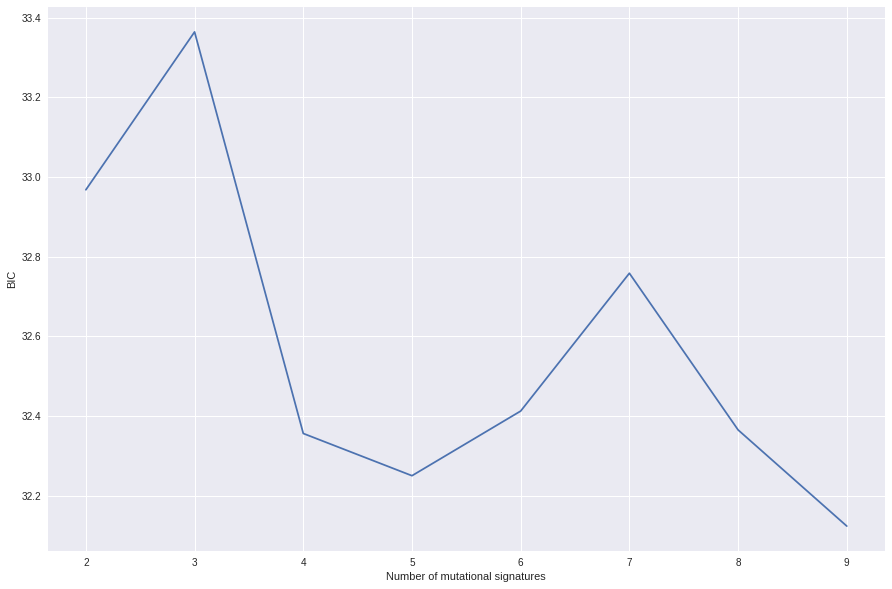

In [31]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(2,10), BIC)
plt.xlabel("Number of mutational signatures")
plt.ylabel("BIC")

In [22]:
C,D = results[3].best_estimator_.decomposition()
D = add_removed_cols(D, removed_cols)
D_ordered = ordering_for_types(D, types)

In [ ]:
C = np.load("breast25_ourMethod/coefficients.npy")
D = np.load("breast25_ourMethod/dictionary.npy")
D_ordered = np.load("breast25_ourMethod/dictionary_ordered.npy")

In [35]:
np.save("breast25_ourMethod/good_best_estimator_8may.npy", results[3].best_estimator_)
np.save("breast25_ourMethod/good_dictionary_8may.npy", D)
np.save("breast25_ourMethod/good_dictionary_ordered_8may.npy", D_ordered)
np.save("breast25_ourMethod/good_coefficients_8may.npy", C)
np.save("breast25_ourMethod/good_BICs_8may.npy", BIC)


distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to scheduler
distributed.client - WARNING - Client report stream closed to sc

In [ ]:
print(best_estimator.reconstruction_error())
print(best_estimator.objective_function_value())
print(best_estimator.k)

In [23]:
percentages = np.zeros_like(C)

for sample in range(C.shape[0]):
    total = np.sum(C[sample,:])
    if(total != 0):
        percentages[sample,:] = C[sample, :] / total 

print(percentages)

[[  5.39907416e-02   9.94400053e-02   2.34600434e-01   5.66525199e-01
    4.54436203e-02]
 [  3.46213306e-01   1.56857110e-01   2.53401522e-01   6.84597672e-02
    1.75068295e-01]
 [  1.11885851e-01   2.93460514e-01   2.18058802e-01   1.08021977e-01
    2.68572856e-01]
 [  2.69243422e-01   1.61543777e-01   2.84227151e-01   9.45026445e-02
    1.90483006e-01]
 [  2.17705404e-01   5.32522131e-01   1.82406648e-01   9.31291886e-03
    5.80528976e-02]
 [  3.05222773e-01   1.58516784e-01   6.32178316e-02   1.71905336e-02
    4.55852078e-01]
 [  2.61224051e-01   1.05965023e-01   5.22356367e-01   1.10454559e-01
    0.00000000e+00]
 [  8.64694007e-02   2.53886063e-01   1.34002918e-01   5.25641619e-01
    0.00000000e+00]
 [  2.52885698e-01   7.42195882e-02   1.02069059e-01   1.75433229e-01
    3.95392425e-01]
 [  1.21244000e-01   1.59921939e-01   3.61943099e-02   6.06999547e-01
    7.56402036e-02]
 [  6.17873139e-02   2.11815487e-01   0.00000000e+00   3.82029757e-01
    3.44367442e-01]
 [  0.0000

In [24]:
max_indices = np.zeros((percentages.shape[1]))
max_values = np.zeros((percentages.shape[1]))

for atom in range(percentages.shape[1]):
    max_indices[atom] = np.argmax(percentages[:,atom])
    max_values[atom] = percentages[int(max_indices[atom]), atom]

In [ ]:
atom=0
print("The percentages of usage is: ", max_values[atom])

sample = data[int(max_indices[atom]), :]
plot_coverage(D[atom,:]*C[int(max_indices[atom]), atom], sample)

In [ ]:
atom=1
print("The percentages of usage is: ", max_values[atom])

sample = data[int(max_indices[atom]), :]
plot_coverage(D[atom,:]*C[int(max_indices[atom]), atom], sample)

In [ ]:
atom=2
print("The percentages of usage is: ", max_values[atom])

sample = data[int(max_indices[atom]), :]
plot_coverage(D[atom,:]*C[int(max_indices[atom]), atom], sample)

In [ ]:
atom=3
print("The percentages of usage is: ", max_values[atom])

sample = data[int(max_indices[atom]), :]
plot_coverage(D[atom,:]*C[int(max_indices[atom]), atom], sample)

In [ ]:
atom=4
print("The percentages of usage is: ", max_values[atom])

sample = data[int(max_indices[atom]), :]
plot_coverage(D[atom,:]*C[int(max_indices[atom]), atom], sample)

In [ ]:
atom=5
print("The percentages of usage is: ", max_values[atom])

sample = data[int(max_indices[atom]), :]
plot_coverage(D[atom,:]*C[int(max_indices[atom]), atom], sample)

(21, 5)
[[  5.39907416e-02   9.94400053e-02   2.34600434e-01   5.66525199e-01
    4.54436203e-02]
 [  3.46213306e-01   1.56857110e-01   2.53401522e-01   6.84597672e-02
    1.75068295e-01]
 [  1.11885851e-01   2.93460514e-01   2.18058802e-01   1.08021977e-01
    2.68572856e-01]
 [  2.69243422e-01   1.61543777e-01   2.84227151e-01   9.45026445e-02
    1.90483006e-01]
 [  2.17705404e-01   5.32522131e-01   1.82406648e-01   9.31291886e-03
    5.80528976e-02]
 [  3.05222773e-01   1.58516784e-01   6.32178316e-02   1.71905336e-02
    4.55852078e-01]
 [  2.61224051e-01   1.05965023e-01   5.22356367e-01   1.10454559e-01
    0.00000000e+00]
 [  8.64694007e-02   2.53886063e-01   1.34002918e-01   5.25641619e-01
    0.00000000e+00]
 [  2.52885698e-01   7.42195882e-02   1.02069059e-01   1.75433229e-01
    3.95392425e-01]
 [  1.21244000e-01   1.59921939e-01   3.61943099e-02   6.06999547e-01
    7.56402036e-02]
 [  6.17873139e-02   2.11815487e-01   0.00000000e+00   3.82029757e-01
    3.44367442e-01]
 [

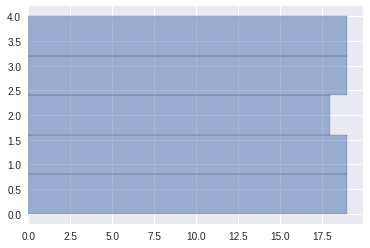

In [25]:
print(percentages.shape)
print(percentages)
frequencies = np.zeros(D.shape[0])
print(percentages.shape)
for atom in range(percentages.shape[1]):
    frequencies[atom]= len(np.nonzero(percentages[:,atom])[0])
print(frequencies)
plt.figure()
plt.hist(np.arange(D.shape[0]),weights=frequencies, bins=D.shape[0], orientation="horizontal", alpha=0.5, histtype='bar', ec='black');
plt.show()

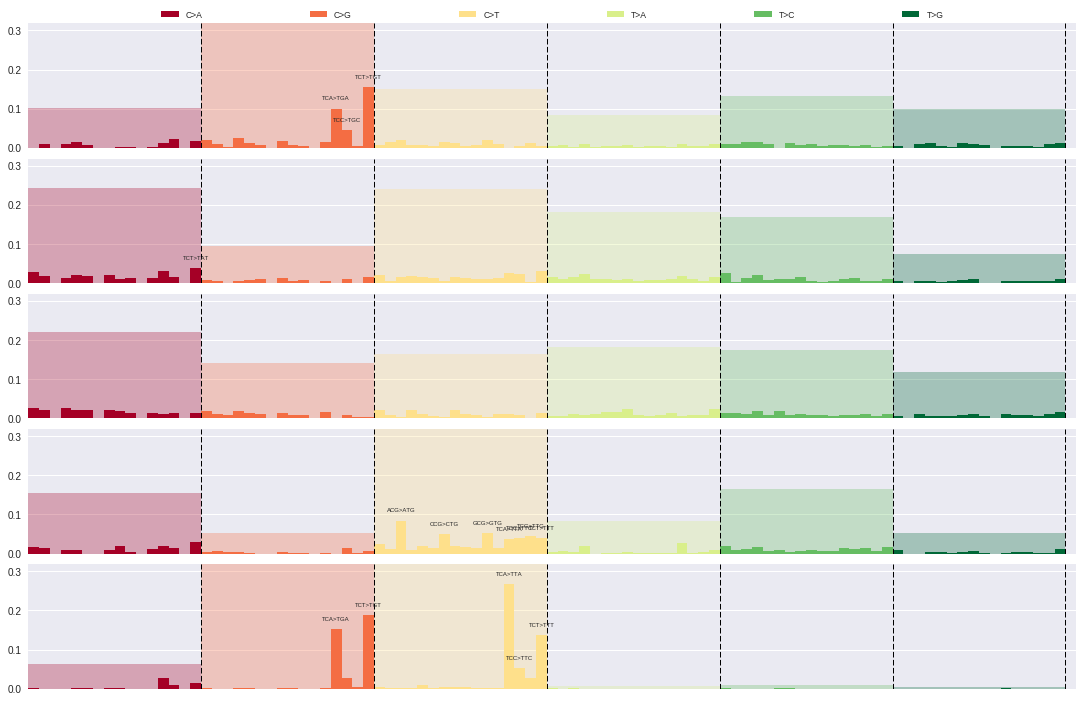

In [26]:
plot_genome_mutations(D_ordered)

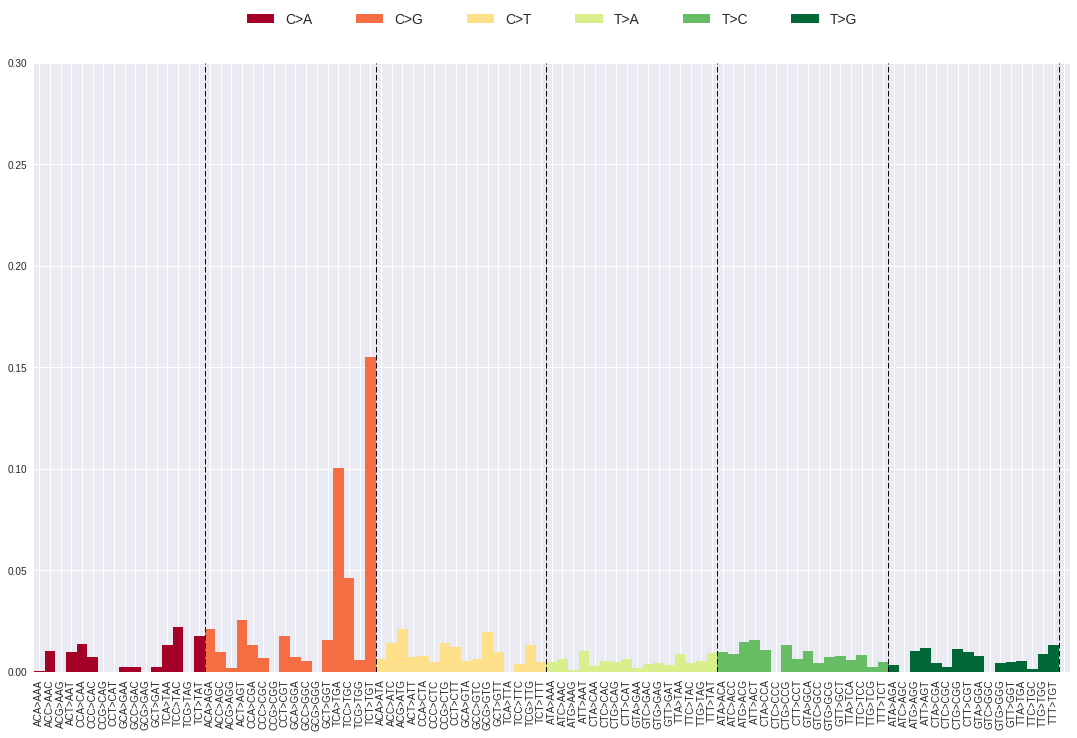

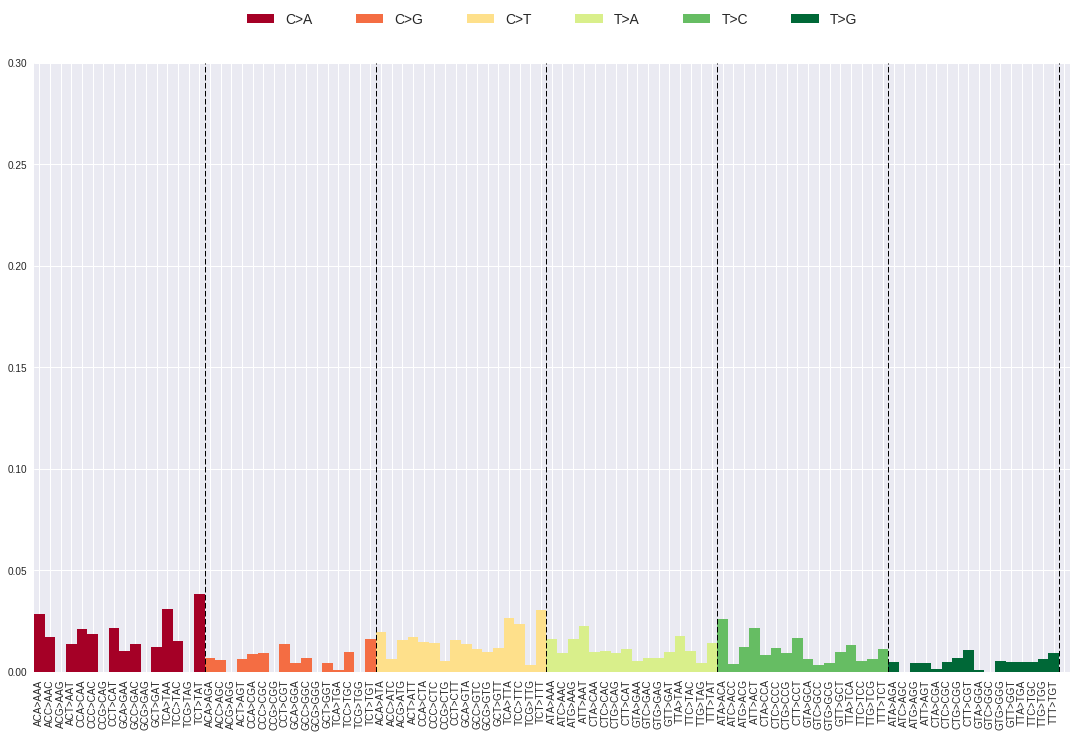

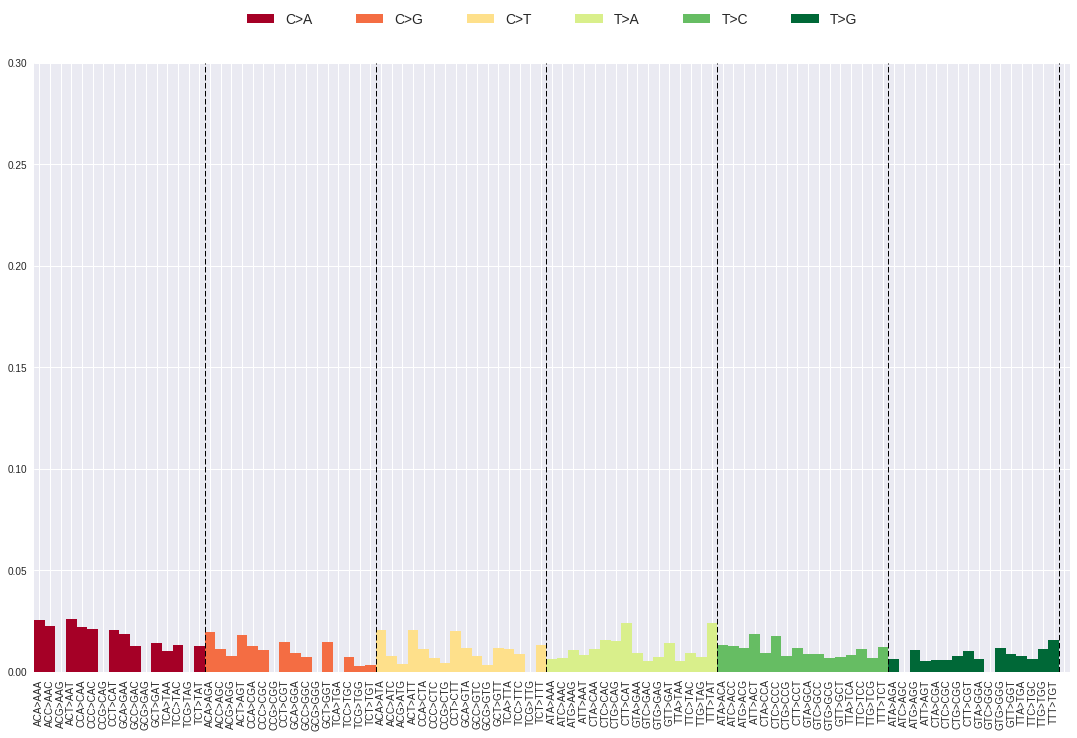

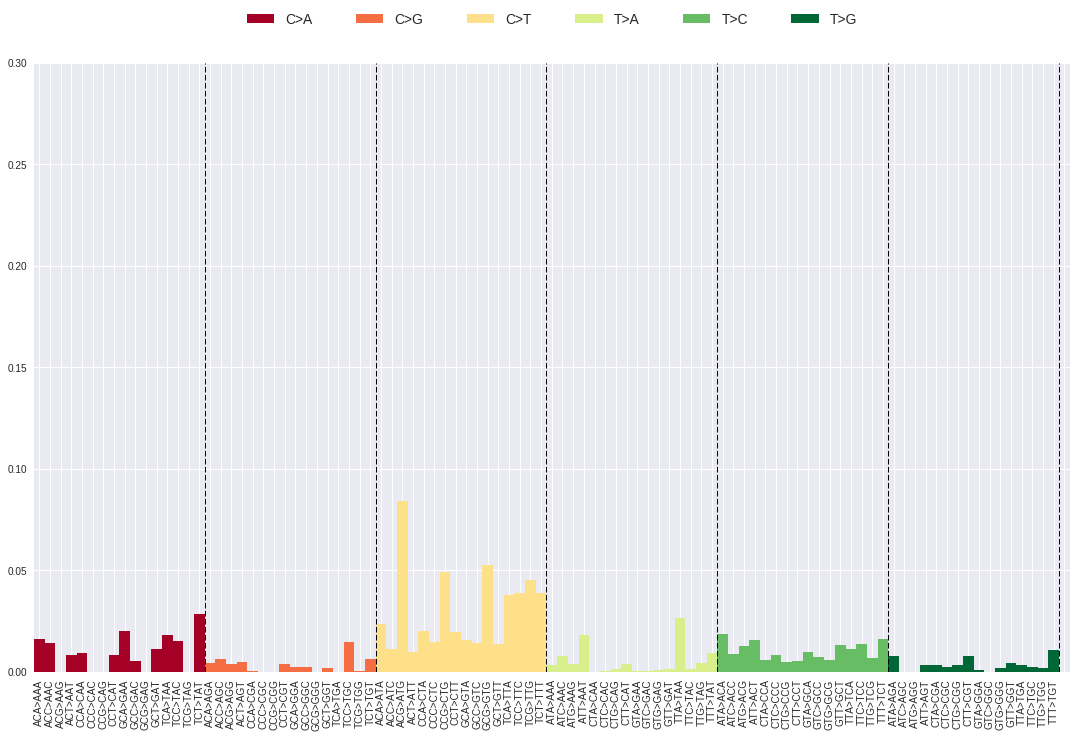

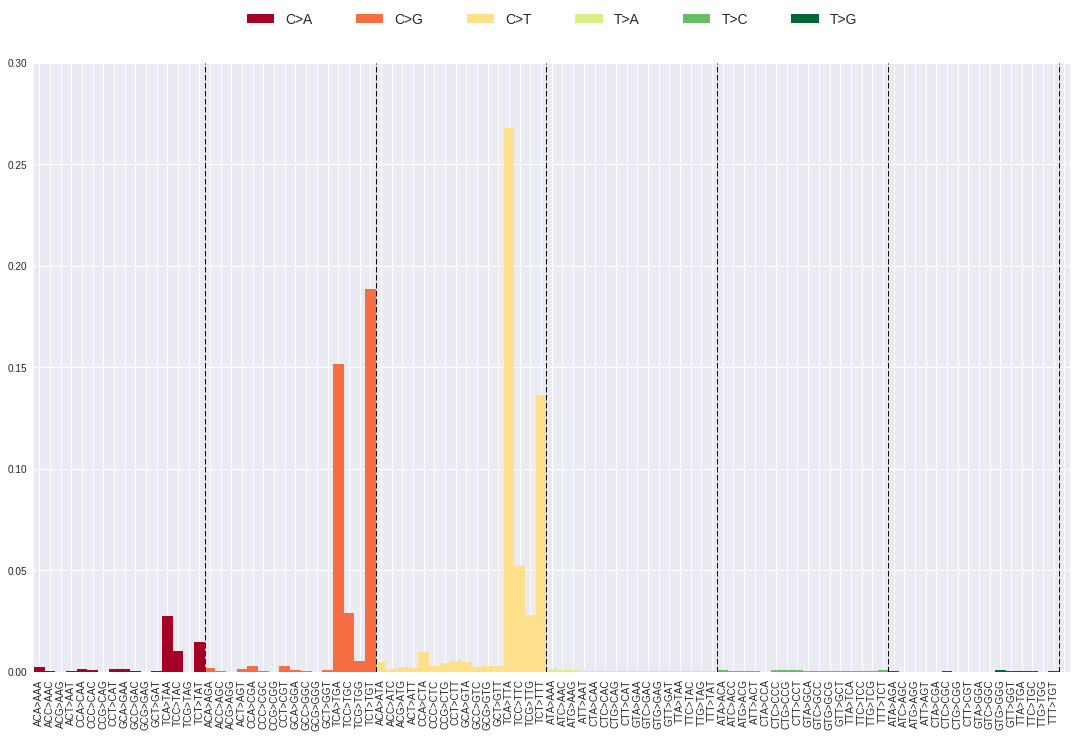

In [33]:
for i in range(D_ordered.shape[0]):
    plot_atom(D_ordered[i,:])
    plt.savefig('breast25_ourMethod/good_atom'+str(i)+".png")

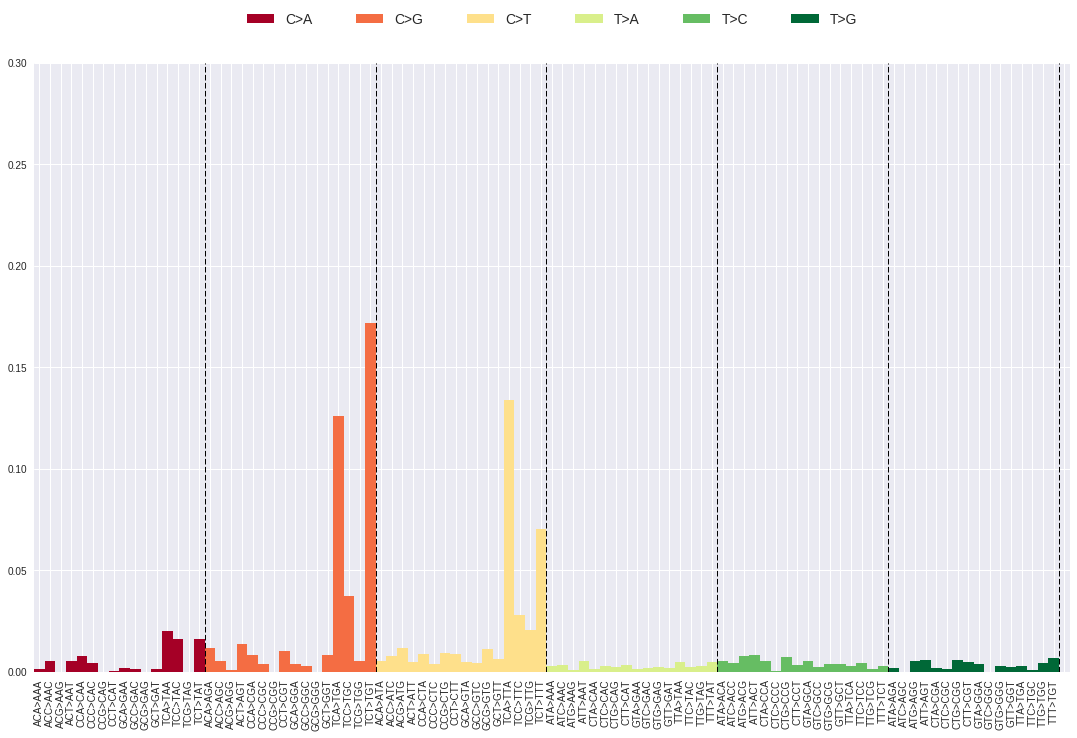

In [27]:
_sum = D_ordered[0,:] + D_ordered[4, :]
_sum /= np.sum(_sum)
plot_atom(_sum)